In [1]:
import pandas as pd, numpy as np, os
from PIL import Image 
import tensorflow as tf
import cv2, keras, gc
import keras.backend as K
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt, time
from sklearn.metrics import roc_auc_score, accuracy_score


In [2]:
path_train ='train_images/'
path_test = 'test_images/'

In [3]:
sub = pd.read_csv('sample_submission.csv')
sub.head()

Image_Label EncodedPixels
0    002f507.jpg_Fish           1 1
1  002f507.jpg_Flower           1 1
2  002f507.jpg_Gravel           1 1
3   002f507.jpg_Sugar           1 1
4    0035ae9.jpg_Fish           1 1

In [5]:
df_train = pd.read_csv('train.csv')
df_train['Image'] = df_train['Image_Label'].map(lambda x: x.split('.')[0])
df_train['Label'] = df_train['Image_Label'].map(lambda x: x.split('_')[1])
df_train['Image'] = df_train['Image'] + '.jpg'


In [6]:
df_train['im'] = df_train['Image_Label'].map(lambda x: x.split('.')[0])

In [7]:
df_train['path_train'] = path_train+df_train['Image']
df_train = df_train.dropna(how='any')

In [8]:
df_train.head()


Image_Label                                      EncodedPixels  \
0    0011165.jpg_Fish  264918 937 266318 937 267718 937 269118 937 27...   
1  0011165.jpg_Flower  1355565 1002 1356965 1002 1358365 1002 1359765...   
4    002be4f.jpg_Fish  233813 878 235213 878 236613 878 238010 881 23...   
5  002be4f.jpg_Flower  1339279 519 1340679 519 1342079 519 1343479 51...   
7   002be4f.jpg_Sugar  67495 350 68895 350 70295 350 71695 350 73095 ...   

         Image   Label       im                path_train  
0  0011165.jpg    Fish  0011165  train_images/0011165.jpg  
1  0011165.jpg  Flower  0011165  train_images/0011165.jpg  
4  002be4f.jpg    Fish  002be4f  train_images/002be4f.jpg  
5  002be4f.jpg  Flower  002be4f  train_images/002be4f.jpg  
7  002be4f.jpg   Sugar  002be4f  train_images/002be4f.jpg

In [9]:

df_train.reset_index(drop=True, inplace=True)


In [10]:
print(df_train['im'][2])

002be4f


In [25]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11836 entries, 0 to 22181
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Image_Label    11836 non-null  object
 1   EncodedPixels  11836 non-null  object
 2   Image          11836 non-null  object
 3   Label          11836 non-null  object
 4   im             11836 non-null  object
 5   path_train     11836 non-null  object
dtypes: object(6)
memory usage: 647.3+ KB


In [11]:
def rle2mask(mask_rle, shape=(2100,1400), shrink=1):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T[::shrink,::shrink]

def rle2bb(rle):
    if rle=='': return (0,0,0,0)
    mask = rle2mask(rle)
    z = np.argwhere(mask==1)
    mn_x = np.min( z[:,0] )
    mx_x = np.max( z[:,0] )
    mn_y = np.min( z[:,1] )
    mx_y = np.max( z[:,1] )
    return (mn_x,mn_y,mx_x-mn_x,mx_y-mn_y)

def bb2dice(rle,bb,shape=(2100,1400)):
    mask1 = rle2mask(rle,shape)
    mask2 = np.zeros((shape[1],shape[0]))
    mask2[bb[0]:bb[0]+bb[2],bb[1]:bb[1]+bb[3]]=1
    union = np.sum(mask1) + np.sum(mask2)
    if union==0: return 1
    intersection = np.sum(mask1*mask2)
    return 2.*intersection/union

In [36]:
import pandas as pd


def add_bbox_to_df(df):
   
    for index, row in df.iterrows():
        for i in range(1, 5):  
            mask_rle = row['EncodedPixels']  # RLE correspondant au nuage i
            x, y, w, h = rle2bb(mask_rle)  # Obtenir les coordonnées bbox
            # Ajouter les coordonnées bbox au DataFrame
            df.loc[index, f'x'] = y
            df.loc[index, f'y'] = x
            df.loc[index, f'w'] = h
            df.loc[index, f'h'] = w


add_bbox_to_df(df_train)


In [37]:
df_train.head()

Image_Label                                      EncodedPixels  \
0    0011165.jpg_Fish  264918 937 266318 937 267718 937 269118 937 27...   
1  0011165.jpg_Flower  1355565 1002 1356965 1002 1358365 1002 1359765...   
2    002be4f.jpg_Fish  233813 878 235213 878 236613 878 238010 881 23...   
3  002be4f.jpg_Flower  1339279 519 1340679 519 1342079 519 1343479 51...   
4   002be4f.jpg_Sugar  67495 350 68895 350 70295 350 71695 350 73095 ...   

         Image   Label       im                path_train      x      y  \
0  0011165.jpg    Fish  0011165  train_images/0011165.jpg  189.0  317.0   
1  0011165.jpg  Flower  0011165  train_images/0011165.jpg  968.0  313.0   
2  002be4f.jpg    Fish  002be4f  train_images/002be4f.jpg  167.0    9.0   
3  002be4f.jpg  Flower  002be4f  train_images/002be4f.jpg  956.0  878.0   
4  002be4f.jpg   Sugar  002be4f  train_images/002be4f.jpg   48.0  294.0   

        w       h  
0   994.0   936.0  
1  1126.0  1052.0  
2  1919.0   880.0  
3  1141.0   518.0  
4   896.0   349.0

In [24]:
import matplotlib.pyplot as plt
import tensorflow as tf
folder_images = path_train

@tf.function
def load_image(filepath, resize=None):
    im = tf.io.read_file(filepath)
    im = tf.image.decode_png(im, channels=3)
    if resize:
        return tf.image.resize(im, resize)
    else :
        return im


        

In [10]:
import os
import pandas as pd


file_list = os.listdir(path_test)

# Créez un dataframe à partir de la liste des fichiers
df_test = pd.DataFrame({'filename': file_list})

# Afficher le dataframe
df_test

filename
0     002f507.jpg
1     0035ae9.jpg
2     0038327.jpg
3     004f759.jpg
4     005ba08.jpg
...           ...
3693  ffadb3a.jpg
3694  ffc72da.jpg
3695  ffcf5b0.jpg
3696  ffe0620.jpg
3697  fff3c5c.jpg

[3698 rows x 1 columns]

In [11]:
df_test['path_test'] = path_test + df_test['filename']


In [12]:
df_test.head()

filename                path_test
0  002f507.jpg  test_images/002f507.jpg
1  0035ae9.jpg  test_images/0035ae9.jpg
2  0038327.jpg  test_images/0038327.jpg
3  004f759.jpg  test_images/004f759.jpg
4  005ba08.jpg  test_images/005ba08.jpg

In [17]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import tensorflow

In [39]:
df_train.head()

Image_Label                                      EncodedPixels  \
0    0011165.jpg_Fish  264918 937 266318 937 267718 937 269118 937 27...   
1  0011165.jpg_Flower  1355565 1002 1356965 1002 1358365 1002 1359765...   
2    002be4f.jpg_Fish  233813 878 235213 878 236613 878 238010 881 23...   
3  002be4f.jpg_Flower  1339279 519 1340679 519 1342079 519 1343479 51...   
4   002be4f.jpg_Sugar  67495 350 68895 350 70295 350 71695 350 73095 ...   

         Image   Label       im                path_train      x      y  \
0  0011165.jpg    Fish  0011165  train_images/0011165.jpg  189.0  317.0   
1  0011165.jpg  Flower  0011165  train_images/0011165.jpg  968.0  313.0   
2  002be4f.jpg    Fish  002be4f  train_images/002be4f.jpg  167.0    9.0   
3  002be4f.jpg  Flower  002be4f  train_images/002be4f.jpg  956.0  878.0   
4  002be4f.jpg   Sugar  002be4f  train_images/002be4f.jpg   48.0  294.0   

        w       h  
0   994.0   936.0  
1  1126.0  1052.0  
2  1919.0   880.0  
3  1141.0   518.0  
4   896.0   349.0

In [43]:
!pip install openpyxl


     ------------------------------------ 250.0/250.0 kB 243.4 kB/s eta 0:00:00


In [44]:
from IPython import display
df_train.to_excel('df_train.xlsx',index=False)

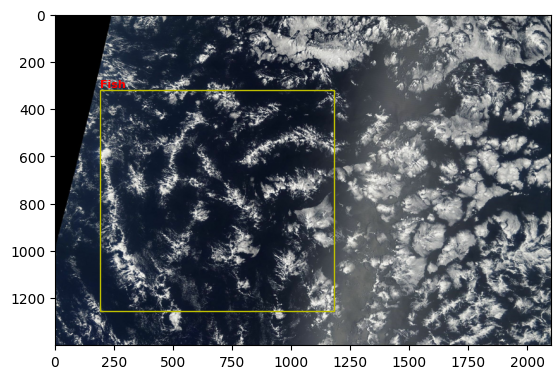

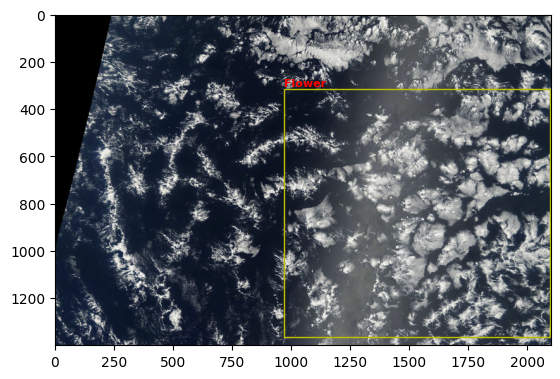

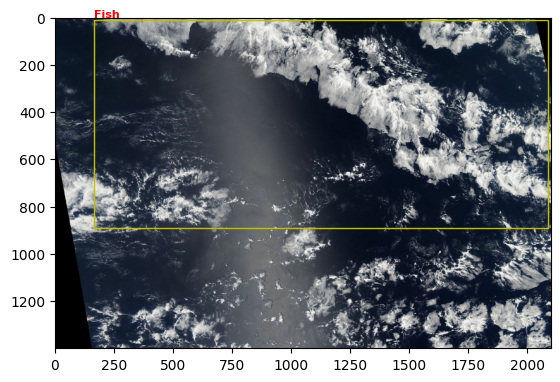

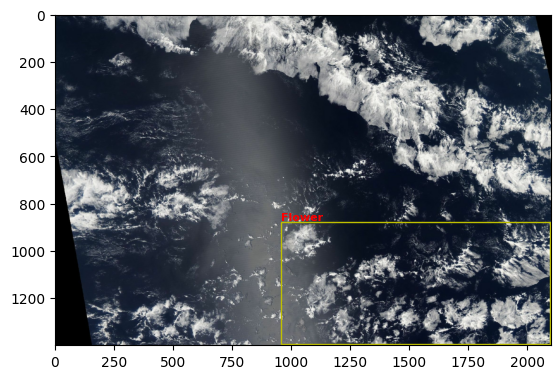

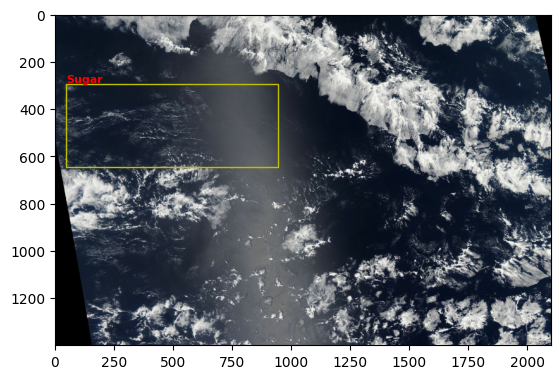

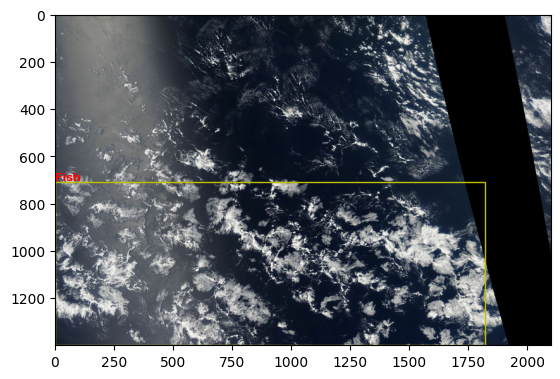

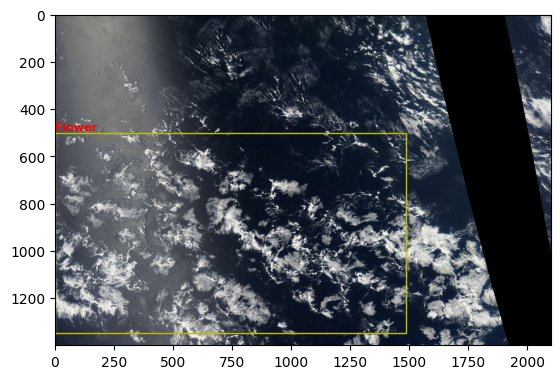

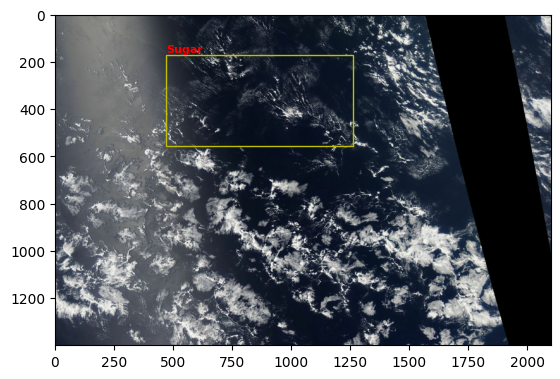

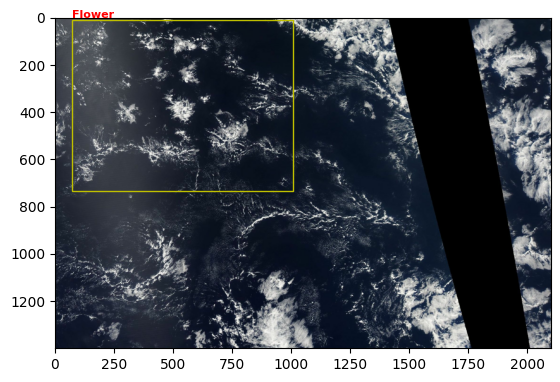

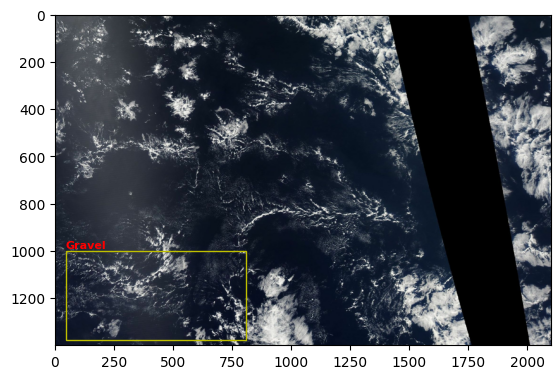

In [40]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Parcourez les lignes du DataFrame
for i in range(10):
    im = load_image(df_train['path_train'][i]) 
    # Obtenez les coordonnées x, y, w, h pour la ligne actuelle du DataFrame
    x = df_train['x'].iloc[i]
    y = df_train['y'].iloc[i]
    w = df_train['w'].iloc[i]
    h = df_train['h'].iloc[i]

    # Créez le rectangle basé sur ces coordonnées
    rectangle = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='y', facecolor='none')
    
    # Ajoutez le rectangle à l'image
    plt.gca().add_patch(rectangle)
    label_text = df_train['Label'][i]

    # Ajoutez le label associé au rectangle
    plt.text(x, y - 10, label_text, color='red', fontsize=8, fontweight='bold')
# Affichez l'image avec les rectangles
    plt.imshow(im)  
    plt.show()
